## Real Time Analytics Final Project

<b> CryptoStreamLab: Real-Time Analysis of Cryptocurrency Markets Using Streaming Data </b> \
An Exploration of Real-Time Price and Volume Analysis with Spark, Kafka, and Streamlit for Enhanced Trading Strategies 

<b> Author:\
    1. Cuong Vo - 131116\
    2. Trang Linh Nguyen - 131036\
    3. Aisel Akhmedova - 131008 </b>

Tech Stack:\
    **1. Spark:** 3.5.0\
    **2. Python:** 3.10.12\
    **3. OS:** WSL Linux\
    **4. Streamlit:** \
    **5. Scala:** 2.12.18\
    **6. Java OpenJDK 64-Bit Server VM:** 11.0.25 \
    **7. Spark-submit:** org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0 


## Abstract

This project explores the development of a real-time cryptocurrency trading system by leveraging modern streaming technologies and technical analysis. Using **Apache Kafka** for data ingestion, **Apache Spark Structured Streaming** for real-time processing, and **Streamlit** for live visualization, the system continuously streams market data from the **Binance API**. A trading strategy is implemented based on the **Relative Strength Index (RSI)** and **moving average crossovers**, generating buy, sell, or hold signals in real-time. The architecture supports immediate signal evaluation and portfolio adjustment, simulating trades using live data. The project demonstrates how scalable streaming tools can be combined with financial analytics to build a responsive and testable trading platform.


## Data Description

The dataset consists of real-time cryptocurrency market data streamed from Binance. Each record includes the following fields:

- **Ticker**: The symbol representing the cryptocurrency pair BTCUSDT.
- **Timestamp**: The date and time when the data was recorded.
- **Open**: The opening price of the cryptocurrency for the given time interval.
- **Close**: The closing price of the cryptocurrency for the given time interval.
- **Price**: The current price at the time of data capture.
- **Volume**: The total trading volume of the cryptocurrency during the interval.

This data enables real-time analysis of price movements and trading activity for various cryptocurrencies.

## Kafka Server setup

Kafka Server is created on <b>localhost:9092</b> on WSL Linux Environment

In [ ]:
$ sudo systemctl daemon-reload
$ sudo systemctl start zookeeper
$ sudo systemctl start kafka

To check status of Kafka Server

In [ ]:
$ sudo systemctl status kafka 

## Streaming Data

### Create Kafka topic
In this part, using Linux to create Kafka topic name StreamQuant

In [ ]:
$ cd /usr/local/kafka 
$ bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --topic StreamQuant

Check for topic

In [ ]:
$ bin/kafka-topics.sh --list --bootstrap-server localhost:9092

### Create Kafka Procedure
In this part, combined with the API key from Binance, we pull the data from Binance and send it to Kakfa producer

In [ ]:
from binance.client import Client
from kafka import KafkaProducer
import json
import time

#  using API keys
api_key = 'giuBTEvNmtfaSuPpCZfmF7uXzRYfKzk7sAwC4ezjB3KbfGLS30UnQMDxcxs15WSB'
api_secret = 'SOmHSWFBuTa20grpf8r87c9qm9tym1oHkjktpu4mIwB9L08qvXW4W9HK7FSt1y6o'

client = Client(api_key, api_secret)

def get_historical_data(symbol, interval, lookback):
    """
    Fetch historical data from Binance for a given symbol and interval.
    :param symbol: The trading pair symbol (e.g., 'BTCUSDT').
    :param interval: The time interval for the data (e.g., '1m', '5m', '1h', '1d').
    :param lookback: The lookback period for the data (e.g., '1 day ago UTC', '1 hour ago UTC').
    """
    try:
        klines = client.get_historical_klines(symbol, interval, lookback)
        return klines
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None
    
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',  # Replace with your Kafka broker if different
    value_serializer=lambda v: json.dumps(v).encode('utf-8')  # Serialize to JSON bytes
)

topic = 'StreamQuant'

i = 0

keys = ["timestamp", "open", "high", "low", "close", "volume"]

binance_data = get_historical_data('BTCUSDT', '1m', '6 hours ago UTC')

print("Fetching initial data for 6 hours...")

for cryto_data in binance_data:
    values = [int(cryto_data[0])] + [float(x) for x in cryto_data[1:]]
    data_dict = dict(zip(keys, values))
    producer.send(topic, value=data_dict)
    print(f"Sent {topic} - {i}: {data_dict}")

print("Streaming data every minute...")

while True:
    i +=1
    binance_data = get_historical_data('BTCUSDT', '1m', '1 minute ago UTC')
    values = [int(binance_data[0][0])] + [float(x) for x in binance_data[0][1:]]
    data_dict = dict(zip(keys, values))
    producer.send(topic, value=data_dict)
    print(f"Sent {topic} - {i}: {data_dict}")
    time.sleep(60)  # Sleep for 1 minute before fetching the next data point

Run Producer

In [ ]:
$ python3 binance_producer.py

### Create Kafka Consumer

In [ ]:
from pyspark.sql.types import StructType, DoubleType, StructField, LongType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("StreamQuant").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

schema = StructType([
  StructField('timestamp', LongType()),
  StructField('open', DoubleType()),
  StructField('high', DoubleType()),
  StructField('low', DoubleType()),
  StructField('close', DoubleType()),
  StructField('volume', DoubleType())
])

df_raw = spark.readStream.format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "StreamQuant") \
    .option("startingOffsets", "latest") \
    .load()

df_raw = df_raw.selectExpr("CAST(value AS STRING)")

df_raw = df_raw.withColumn("value", F.from_json(df_raw.value, schema))\
    .select("value.*")  

df_raw = df_raw.withColumn("datetime", F.from_unixtime(F.col("timestamp") / 1000))

df_raw.writeStream \
 .format("parquet") \
 .option("path", "/tmp/stream_output/") \
 .option("checkpointLocation", "/tmp/stream_checkpoint/") \
 .outputMode("append") \
 .start() \
 .awaitTermination()

Running Consumer

In [ ]:
$ spark-submit --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0 ~/Realtime_Analytics/quant_consumer.py

## Trading Strategy

The strategy identifies potential buying and selling opportunities based on a combination of technical indicators: the Relative Strength Index (RSI) and moving average crossovers. A BUY signal is generated when the RSI is above 50 but below 70, and a bullish crossover occurs defined as the 20-period moving average crossing above the 50-period moving average. This suggests a strengthening upward trend that has not yet entered overbought territory. Conversely, a SELL signal is triggered when the RSI exceeds 70 and a bearish crossover is detected, where the 20-period moving average crosses below the 50-period moving average, indicating a possible reversal from overbought conditions. In the absence of these conditions, the strategy holds the position (HOLD), avoiding unnecessary trades.

### 📌 Trading Strategy Summary

* **Indicators Used**:

  * RSI (Relative Strength Index)
  * 20-period and 50-period Moving Averages (MA20 & MA50)

* **Buy Signal**:

  * RSI is between **50 and 70**
  * **Bullish crossover**: MA20 crosses **above** MA50 

* **Sell Signal**:

  * RSI is **above 70**
  * **Bearish crossover**: MA20 crosses **below** MA50 

* **Hold**:

  * All other cases — no action taken



## Visualization

In [ ]:
# Libraries import
import streamlit as st
import pandas as pd
import numpy as np
import time
import os
import plotly.graph_objects as go
from pyspark.sql.types import StructType, DoubleType, StructField, LongType
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from  pyspark.sql.functions import *

# Define the Spark session and schema
spark = SparkSession.builder.appName("TradingDashboard").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

schema = StructType([
  StructField('timestamp', LongType()),
  StructField('open', DoubleType()),
  StructField('high', DoubleType()),
  StructField('low', DoubleType()),
  StructField('close', DoubleType()),
  StructField('volume', DoubleType())
])

# Streamlit app
st.set_page_config(page_title="📈 Real-Time Trading Dashboard", layout="wide")
st.title("📊 Real-Time Trading with Candlestick, MA, RSI & Signals")

DATA_DIR = "/tmp/stream_output/"
# Refresh every 65 seconds
REFRESH_INTERVAL = 65

chart_placeholder = st.empty()

def load_data():
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".parquet")]
    if not files:
        return spark.createDataFrame([], schema)

    df = spark.read.parquet(f"{DATA_DIR}*.parquet")
    df = df.dropDuplicates().orderBy("timestamp")
    return df

def compute_indicators(df):
    window_spec_20 = Window.orderBy("datetime").rowsBetween(-19, 0)  
    window_spec_50 = Window.orderBy("datetime").rowsBetween(-49, 0)

    df = df.withColumn("MA20", avg("close").over(window_spec_20))
    df = df.withColumn("MA50", avg("close").over(window_spec_50))

    window_spec = Window.orderBy("datetime")
    df = df.withColumn("prev_close", lag("close", 1).over(window_spec))
    df = df.withColumn("change", col("close") - col("prev_close"))
    df = df.withColumn("gain", when(col("change") > 0, col("change")).otherwise(0))
    df = df.withColumn("loss", when(col("change") < 0, -col("change")).otherwise(0))

    rsi_window = Window.orderBy("datetime").rowsBetween(-13, 0)
    df = df.withColumn("avg_gain", avg("gain").over(rsi_window))
    df = df.withColumn("avg_loss", avg("loss").over(rsi_window))

    df = df.withColumn("rs", col("avg_gain") / col("avg_loss"))
    df = df.withColumn("RSI", 100 - (100 / (1 + col("rs"))))

    df = df.withColumn("prev_MA20", lag("MA20", 1).over(window_spec))
    df = df.withColumn("prev_MA50", lag("MA50", 1).over(window_spec))

    df = df.withColumn("ma_crossover_up", 
                   when((col("prev_MA20") < col("prev_MA50")) & (col("MA20") > col("MA50")), lit(1)).otherwise(0))

    df = df.withColumn("ma_crossover_down", 
                   when((col("prev_MA20") > col("prev_MA50")) & (col("MA20") < col("MA50")), lit(1)).otherwise(0))
    
    df = df.withColumn("signal", 
                    when((col("RSI") > 50) & (col("ma_crossover_up") == 1) & (col("RSI") < 70), lit("BUY"))
                    .when((col("RSI") > 70) & (col("ma_crossover_down") == 1), lit("SELL"))
                    .otherwise("HOLD")
                    )                       
    df = df.drop("prev_close", "gain", "loss", "avg_gain", "avg_loss", "rs", "change", "ma_crossover_down", "ma_crossover_up", "prev_MA20", "prev_MA50")
    df = df.orderBy(col("timestamp").desc()).limit(240)

    return df

def plot_price_chart(df):
    fig = go.Figure()

    # Candlestick
    fig.add_trace(go.Candlestick(
        x=df["datetime"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="Candlestick"
    ))

    fig.add_trace(go.Scatter(
        x=df["datetime"], y=df["MA20"],
        line=dict(color="green", width=2),
        name="MA_20"
    ))

    fig.add_trace(go.Scatter(
        x=df["datetime"], y=df["MA50"],
        line=dict(color="red", width=2),
        name="MA_50"
    ))

    fig.update_layout(title="📈 Price with MA + Signals",
                      xaxis_title="Time", yaxis_title="Price",
                      xaxis_rangeslider_visible=False,
                      height=600)
    return fig

def plot_rsi(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df["datetime"], y=df["RSI"], line=dict(color="blue")))
    fig.add_hline(y=70, line_dash="dash", line_color="red")
    fig.add_hline(y=30, line_dash="dash", line_color="green")
    fig.update_layout(title="📉 RSI", height=300)
    return fig

def plot_total_asset(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df["timestamp"], y=df["total_value"], line=dict(color="blue")))
    fig.add_hline(y=10000, line_dash="dash", line_color="green")
    fig.add_hline(y=9300, line_dash="dash", line_color="red")
    fig.update_layout(title="📉 Total Asset", height=300)
    return fig

crypto = 0
budget = 10000

def trading_strategy(df):
    global budget, crypto
    latest = df.iloc[0]
    price = latest["close"]
    signal = latest["signal"]
    datetime_str = latest["datetime"]

    if signal == "BUY" and crypto == 0:
        amount = budget // price
        crypto += amount
        budget -= amount * price
        action = "BUY"
    elif signal == "SELL" and crypto > 0:
        amount = crypto
        crypto -= amount
        budget += amount * price
        action = "SELL"
    else:
        action = "HOLD"

    log = pd.DataFrame([{   "timestamp": datetime_str, 
                            "action": action,
                            "crypto": crypto,
                            "price": price,
                            "budget": budget,   
                            "total_value": budget + (crypto * price)                        
                        }])
    
    return log

price_chart_container = st.empty()
rsi_chart_container = st.empty()
lastest_container = st.empty()
log_container = st.empty()
pnl = st.empty()

portfolio_log = pd.DataFrame(columns=["timestamp", "action", "crypto", "price", "budget", "total_value"])

while True:
    df = load_data()

    if df.count() == 0:
        st.warning("⏳ Waiting for Spark to write streaming data...")
    else:
        df = compute_indicators(df)
        df = df.toPandas()

        log = trading_strategy(df)
        portfolio_log = pd.concat([portfolio_log, log], ignore_index=True)

        # Plot charts
        price_fig = plot_price_chart(df)
        pnl_fig = plot_total_asset(portfolio_log)
        rsi_fig = plot_rsi(df)

        # Layout
        price_chart_container.plotly_chart(price_fig, use_container_width=True)
        pnl.plotly_chart(pnl_fig, use_container_width=True)
        rsi_chart_container.plotly_chart(rsi_fig, use_container_width=True)

        with log_container.expander("📜 Trading Log"):
            log_container.dataframe(portfolio_log.sort_values("timestamp", ascending=False).tail(10))

        with lastest_container.expander("📄 Latest Data"):
            lastest_container.dataframe(df.sort_values("datetime", ascending=False).head(10))

    time.sleep(REFRESH_INTERVAL)

For running the visualization

In [ ]:
$ streamlit run app.py

The app will refresh every 65 seconds

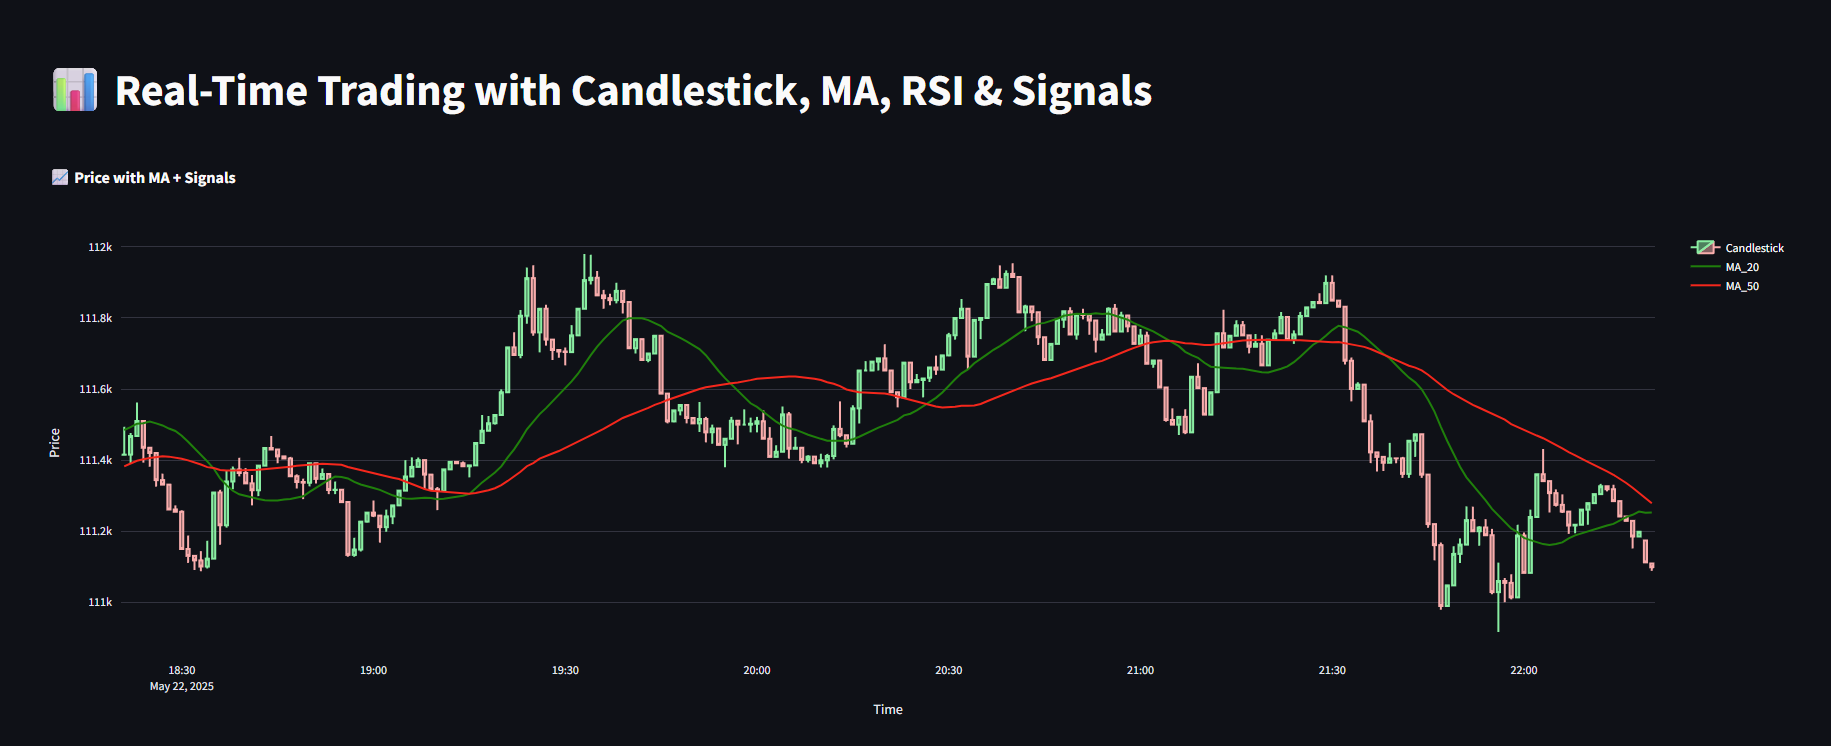

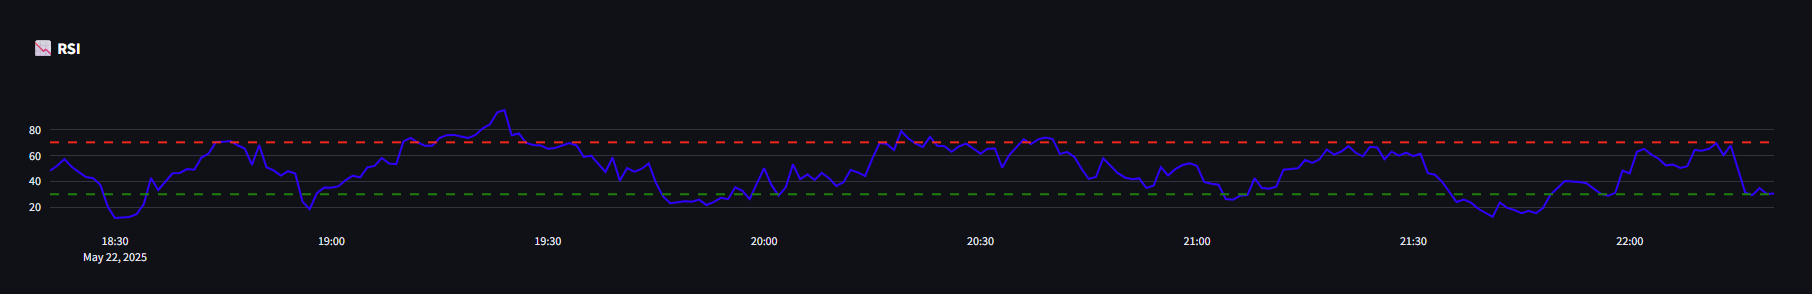

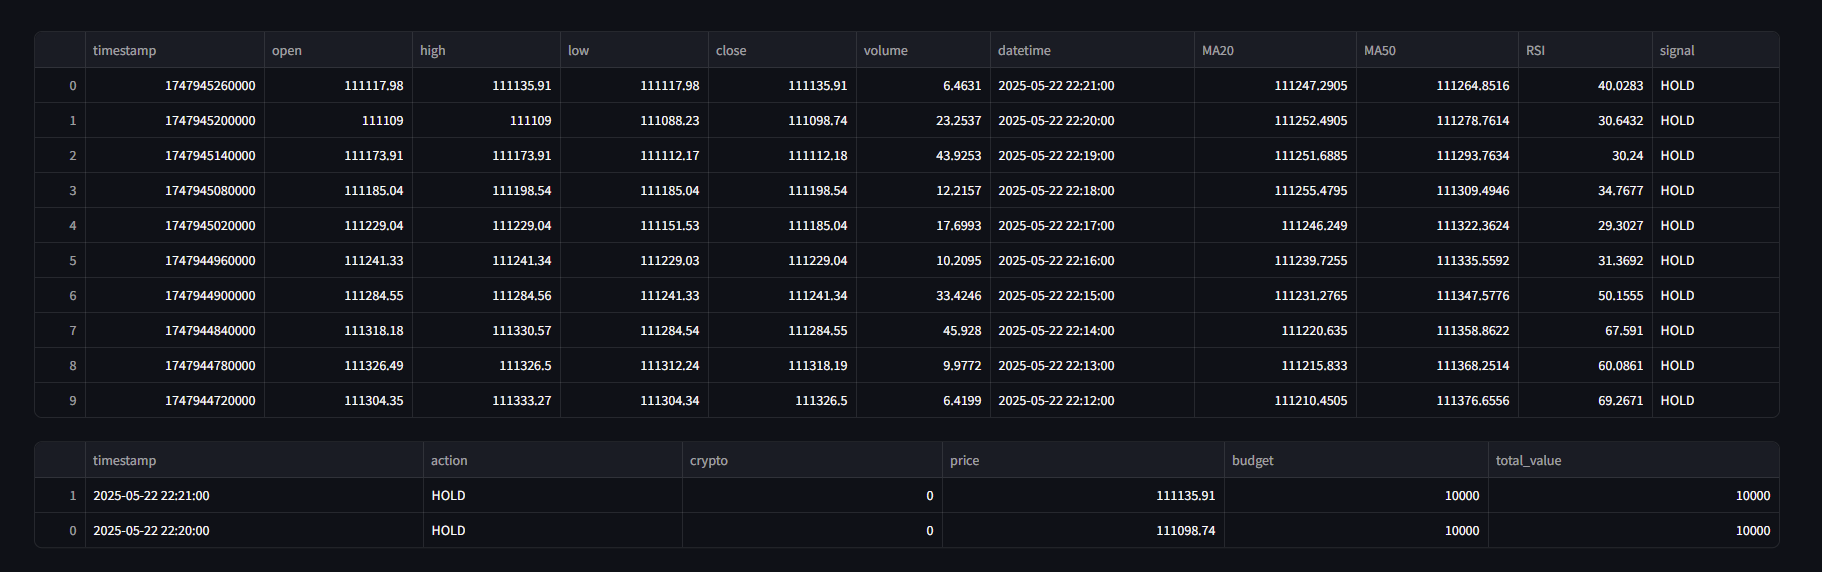

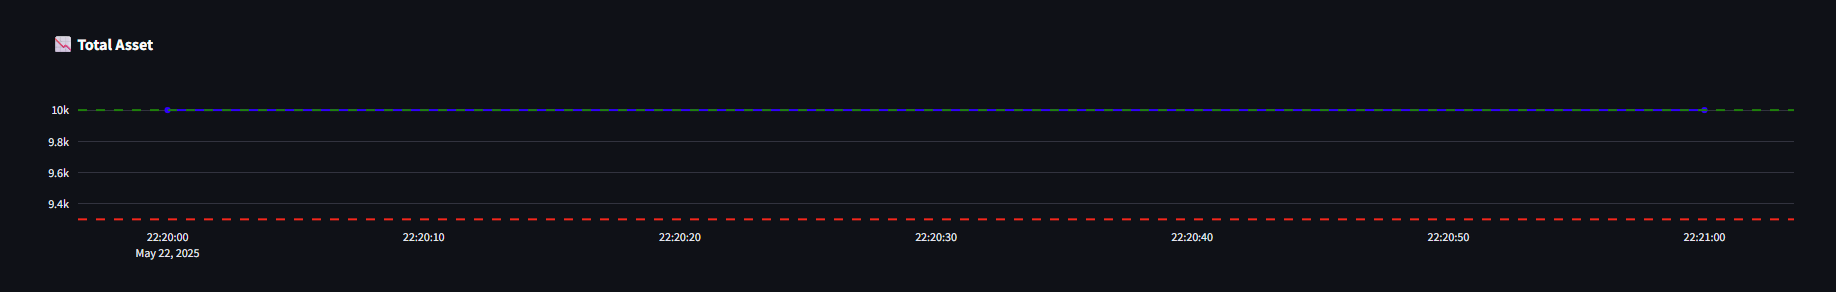

Stop Kafka and Zookeeper

In [ ]:
$ cd /usr/local/kafka
$ sudo bin/zookeeper-server-stop.sh
$ sudo bin/kafka-server-stop.sh